In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from time import time
from pprint import pprint
import ml_collections
from classical_po import ClassicalPO
from jaxopt import BoxOSQP
import jax.numpy as jnp
import jax
from scipy.optimize import minimize
import optuna

# Setting the logging level WARNING, the INFO logs are suppressed.
optuna.logging.set_verbosity(optuna.logging.WARNING)

seed = 42
cfg = ml_collections.ConfigDict()

In [3]:
cfg.hpfilter_lamb = 6.25
cfg.q = 1.0  # risk-aversion factor

# classical
cfg.fmin = 0.002  # 0.001
cfg.fmax = 0.5  # 0.5

In [4]:
tickers = sorted([
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "KOTAKBANK.NS", "ICICIBANK.NS",
    "LT.NS", "AXISBANK.NS", "ITC.NS", "SBIN.NS", "MARUTI.NS", "BAJFINANCE.NS",
    "HINDUNILVR.NS", "BHARTIARTL.NS", "POWERGRID.NS", "NTPC.NS",
    "ULTRACEMCO.NS", "HCLTECH.NS", "SUNPHARMA.NS", "ASIANPAINT.NS", "ONGC.NS",
    "INDUSINDBK.NS", "M&M.NS", "TECHM.NS", "NESTLEIND.NS", "WIPRO.NS",
    "GRASIM.NS", "BRITANNIA.NS", "CIPLA.NS", "BAJAJ-AUTO.NS",
    "HEROMOTOCO.NS", "UPL.NS", "SHREECEM.NS", "IOC.NS",
    "DRREDDY.NS", "HINDALCO.NS", "EICHERMOT.NS", "TATASTEEL.NS",
    "ADANIPORTS.NS", "DIVISLAB.NS",
    "BAJAJHLDNG.NS", "AUROPHARMA.NS"
])

In [5]:
use_local = True

if use_local:
    adj_close_df = pd.read_csv(f'input_data_12_years.csv')
else:
    end_date = datetime.datetime(2021, 1, 1)
    start_date = end_date - datetime.timedelta(days=12 * 365) # 12 years
    
    adj_close_df = pd.DataFrame()

    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)
        adj_close_df[ticker] = data['Adj Close']
    
    adj_close_df.to_csv(f'input_data_12_years.csv')

data = adj_close_df.drop(columns=['Date'])

In [6]:
np.random.seed(seed)
data = data[np.random.choice(data.columns, size=22, replace=False)] 

data = data[data.columns[:18]]

# smooth
for s in data.columns:
    cycle, trend = hpfilter(data[s], lamb=cfg.hpfilter_lamb)
    data[s] = trend

log_returns = np.log(data) - np.log(data.shift(1))
null_indices = np.where((log_returns.isna().sum() > 1).to_numpy())[0]
drop_stocks = data.columns[null_indices]
log_returns = log_returns.drop(columns=drop_stocks)
log_returns = log_returns.dropna()
tickers = log_returns.columns

cfg.num_stocks = len(tickers)

mu = log_returns.mean().to_numpy() * 252
sigma = log_returns.cov().to_numpy() * 252

mu.shape, sigma.shape

((16,), (16, 16))

In [7]:
tickers

Index(['POWERGRID.NS', 'BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'HINDALCO.NS',
       'IOC.NS', 'ULTRACEMCO.NS', 'DRREDDY.NS', 'SUNPHARMA.NS', 'SBIN.NS',
       'TATASTEEL.NS', 'UPL.NS', 'AUROPHARMA.NS', 'ONGC.NS', 'SHREECEM.NS',
       'BAJFINANCE.NS', 'BAJAJHLDNG.NS'],
      dtype='object')

In [8]:
for i in tickers:
    print(f"{i.split('.')[0]},", end=' ')

POWERGRID, BAJAJ-AUTO, BRITANNIA, HINDALCO, IOC, ULTRACEMCO, DRREDDY, SUNPHARMA, SBIN, TATASTEEL, UPL, AUROPHARMA, ONGC, SHREECEM, BAJFINANCE, BAJAJHLDNG, 

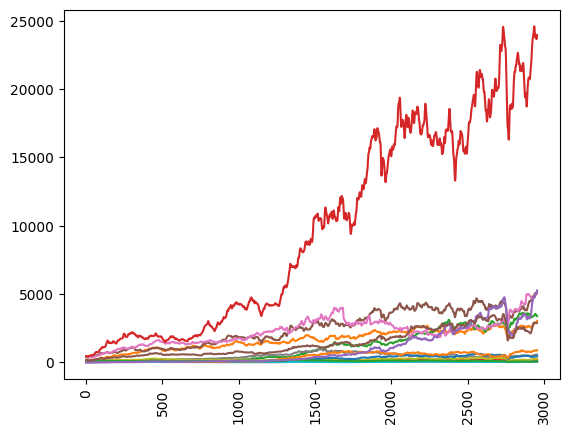

In [9]:
for s in tickers:
    plt.plot(data[s], label=s)
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=90)
plt.show()

In [10]:
cfg.kappa = cfg.num_stocks//2
cfg.kappa

8

## Objectives for optuna

In [11]:
def objective_mvo_miqp(trial, _mu, _sigma):
    cpo = ClassicalPO(_mu, _sigma, cfg)
    cpo.cfg.gamma = trial.suggest_float('gamma', 0.0, 1.5)
    res = cpo.mvo_miqp()
    mvo_miqp_res = cpo.get_metrics(res['w'])
    
    del cpo
    return mvo_miqp_res['sharpe_ratio']

def objective_mvo_rc(trial, _mu, _sigma):
    cpo = ClassicalPO(_mu, _sigma, cfg)
    cpo.cfg.gamma = trial.suggest_float('gamma', 0.0, 1.5)
    res = cpo.mvo_rc()
    mvo_rc_res = cpo.get_metrics(res['w'])
    
    del cpo
    return mvo_rc_res['sharpe_ratio']


def objective_msr(trial, _mu, _sigma, _k):
    cpo = ClassicalPO(_mu, _sigma, cfg)
    cpo.cfg.gamma = trial.suggest_float('gamma', 0.0, 1.5)
    res = cpo.msr(_k)
    msr_res = cpo.get_metrics(res['w'])
    
    del cpo
    return msr_res['sharpe_ratio']

def objective_msr_rc(trial, _mu, _sigma):
    cpo = ClassicalPO(_mu, _sigma, cfg)
    cpo.cfg.gamma = trial.suggest_float('gamma', 0.0, 1.5)
    res = cpo.msr_rc()
    msr_rc_res = cpo.get_metrics(res['w'])
    
    del cpo
    return msr_rc_res['sharpe_ratio']

## MVO

In [12]:
study_mvo_miqp = optuna.create_study(
    study_name='classical_mvo_miqp',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)

study_mvo_miqp.optimize(lambda trial: objective_mvo_miqp(trial, mu, sigma),
                        n_trials=25-len(study_mvo_miqp.trials), n_jobs=1)

trial_mvo_miqp = study_mvo_miqp.best_trial
print(f'Best Sharpe ratio: {trial_mvo_miqp.value}')
print(f"Best gamma: {trial_mvo_miqp.params['gamma']}")

Best Sharpe ratio: 3.7954361547133604
Best gamma: 0.4330661955147394


In [13]:
cpo = ClassicalPO(mu, sigma, cfg)
cpo.cfg.gamma = trial_mvo_miqp.params['gamma']
res = cpo.mvo_miqp()

# show only allocated stocks
weights = res['w']
stock_dict = dict(zip(tickers, np.around(weights, 5)))
stock_dict = {i: j for i, j in stock_dict.items() if j != 0}
pprint(stock_dict)

print(f"\nInvested in {len(stock_dict)}/{len(tickers)} stocks\n")
mvo_miqp_res = cpo.get_metrics(weights)
mvo_miqp_res

{'AUROPHARMA.NS': 0.15948,
 'BAJAJ-AUTO.NS': 0.0714,
 'BAJAJHLDNG.NS': 0.03706,
 'BAJFINANCE.NS': 0.41587,
 'BRITANNIA.NS': 0.11222,
 'DRREDDY.NS': 0.02162,
 'SHREECEM.NS': 0.15479,
 'ULTRACEMCO.NS': 0.02756}

Invested in 8/16 stocks



{'returns': 0.4190846983620323,
 'risk': 0.11041806034376107,
 'sharpe_ratio': 3.7954361547133604,
 'diversification_ratio': 1.3714271611067173}

In [14]:
stock_dict.keys()

dict_keys(['BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'ULTRACEMCO.NS', 'DRREDDY.NS', 'AUROPHARMA.NS', 'SHREECEM.NS', 'BAJFINANCE.NS', 'BAJAJHLDNG.NS'])

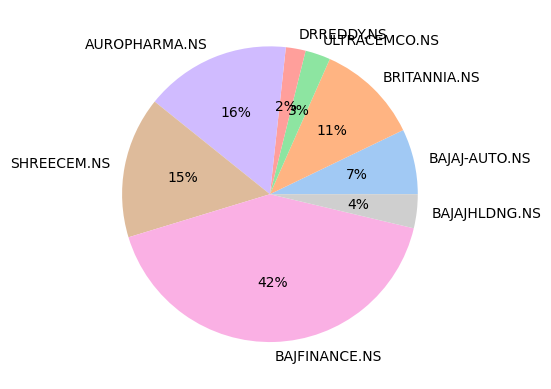

In [15]:
# explode = [0, 0, 0.2, 0.3, 0, 0.0, 0.0, 0.0]
plt.pie(stock_dict.values(), 
        labels=stock_dict.keys(), 
        colors=sns.color_palette('pastel'), 
        autopct='%.0f%%',
#         explode=explode
       )
plt.savefig(f'./results/{cfg.num_stocks}/mvo_miqp.png', bbox_inches='tight', pad_inches=0) 
plt.show()

## MSR

In [16]:
study_msr_rc = optuna.create_study(
    study_name='classical_msr_rc',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)

study_msr_rc.optimize(lambda trial: objective_msr_rc(trial, mu, sigma), 
                      n_trials=25-len(study_msr_rc.trials), n_jobs=1)

trial_msr_rc = study_msr_rc.best_trial
print(f'Best Sharpe ratio: {trial_msr_rc.value}')
print(f"Best gamma: {trial_msr_rc.params['gamma']}")

Best Sharpe ratio: 3.9826850144364854
Best gamma: 0.00045104865544507745


In [17]:
cpo = ClassicalPO(mu, sigma, cfg)
cpo.cfg.gamma = trial_msr_rc.params['gamma']
res = cpo.msr_rc()

# show only allocated stocks
weights = res['w']
stock_dict = dict(zip(tickers, np.around(weights, 5)))
stock_dict = {i: j for i, j in stock_dict.items() if j != 0}
pprint(stock_dict)

print(f"\nInvested in {len(stock_dict)}/{len(tickers)} stocks\n")
msr_rc_res = cpo.get_metrics(weights)
msr_rc_res

{'AUROPHARMA.NS': 0.03402,
 'BAJAJ-AUTO.NS': 0.02463,
 'BAJAJHLDNG.NS': 0.002,
 'BAJFINANCE.NS': 0.34032,
 'BRITANNIA.NS': 0.26614,
 'DRREDDY.NS': 0.16012,
 'HINDALCO.NS': 0.002,
 'IOC.NS': 0.002,
 'ONGC.NS': 0.002,
 'POWERGRID.NS': 0.002,
 'SBIN.NS': 0.002,
 'SHREECEM.NS': 0.15478,
 'SUNPHARMA.NS': 0.002,
 'TATASTEEL.NS': 0.002,
 'ULTRACEMCO.NS': 0.002,
 'UPL.NS': 0.002}

Invested in 16/16 stocks



{'returns': 0.38185003820755137,
 'risk': 0.09587753910324735,
 'sharpe_ratio': 3.9826850144364854,
 'diversification_ratio': 1.448431627954996}

In [18]:
k = np.sum(res['y'])
k

2.618829121228095

In [19]:
study_msr = optuna.create_study(
    study_name='classical_msr',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)

study_msr.optimize(lambda trial: objective_msr(trial, mu, sigma, k)
                   , n_trials=25-len(study_msr.trials), n_jobs=1)

trial_msr = study_msr.best_trial
print(f'Best Sharpe ratio: {trial_msr.value}')
print(f"Best gamma: {trial_msr.params['gamma']}")

Best Sharpe ratio: 3.9803921329003975
Best gamma: 0.009840527425305117


In [20]:
cpo = ClassicalPO(mu, sigma, cfg)
cpo.cfg.gamma = trial_msr.params['gamma']
res = cpo.msr(k)

# show only allocated stocks
weights = res['w']
stock_dict = dict(zip(tickers, np.around(weights, 5)))
stock_dict = {i: j for i, j in stock_dict.items() if j != 0}
pprint(stock_dict)

print(f"\nInvested in {len(stock_dict)}/{len(tickers)} stocks\n")
msr_res = cpo.get_metrics(weights)
msr_res

{'AUROPHARMA.NS': 0.07663,
 'BAJAJ-AUTO.NS': 0.08153,
 'BAJFINANCE.NS': 0.32097,
 'BRITANNIA.NS': 0.21065,
 'DRREDDY.NS': 0.12825,
 'SHREECEM.NS': 0.16476,
 'SUNPHARMA.NS': 0.01521,
 'ULTRACEMCO.NS': 0.00199}

Invested in 8/16 stocks



{'returns': 0.38082861145324276,
 'risk': 0.09567615419231167,
 'sharpe_ratio': 3.9803921329003975,
 'diversification_ratio': 1.4699575644246146}

In [21]:
stock_dict.keys()

dict_keys(['BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'ULTRACEMCO.NS', 'DRREDDY.NS', 'SUNPHARMA.NS', 'AUROPHARMA.NS', 'SHREECEM.NS', 'BAJFINANCE.NS'])

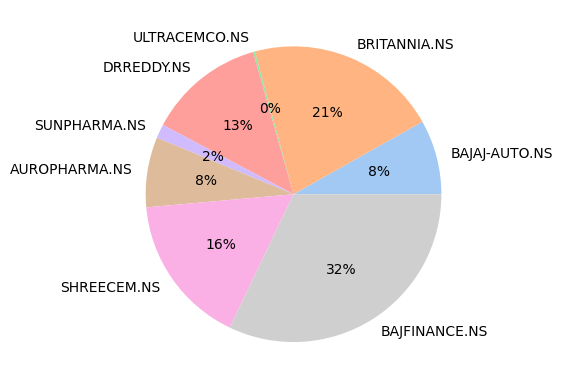

In [22]:
# explode = [0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0.0]
# explode = [0,0,0,0,0,0.4,0.1,0,0,0]
plt.pie(stock_dict.values(), 
        labels=stock_dict.keys(), 
        colors=sns.color_palette('pastel'), 
        autopct='%.0f%%',
#         explode=explode
       )
plt.savefig(f'./results/{cfg.num_stocks}/msr.png', bbox_inches='tight', pad_inches=0) 
plt.show()

## QAOA

In [23]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Sampler
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import SPSA, COBYLA, SLSQP

# QAOA specifc configuration
opt_max_iter = 1000

def create_problem(_mu, _sigma, q, budget):
    
    n = len(_mu)
    mdl = Model(name="mvo_rc")
    x = mdl.binary_var_list(range(n), name="x")

    objective = cfg.q * (x @ _sigma @ x) - _mu @ x

    # investment constraint
    mdl.add_constraint(mdl.sum(x) == budget)
    mdl.minimize(objective)
    
    qp = from_docplex_mp(mdl)
    return qp

qp = create_problem(mu, sigma, cfg.q, cfg.kappa)
qubo = QuadraticProgramToQubo().convert(qp)
qubit_op, offset =qubo.to_ising()

In [24]:
qaoa = QAOA(
    sampler=Sampler(options={"seed": seed}),
    optimizer=COBYLA(maxiter=opt_max_iter),
    reps=1,
)

start = time()
qaoa_result = qaoa.compute_minimum_eigenvalue(qubit_op)
end = time()
print("Duration:", end-start)

opt_bitstring = qaoa_result.best_measurement["bitstring"][::-1]
print("Optimal bitstring:", opt_bitstring)

# select asset from bitstring
assets = []
for i, val in enumerate(opt_bitstring):
    if val == "1":
        assets.append(tickers[i])

Duration: 305.43989729881287
Optimal bitstring: 0110011000010111


result with 20 assets: 01100111000101110100

In [25]:
# Reduced sigma and mu
idxs = np.nonzero([int(bit) for bit in opt_bitstring])[0]
r_sigma = sigma[idxs][:, idxs]
r_mu = mu[idxs]
print(r_sigma.shape, r_mu.shape)

(8, 8) (8,)


### MVO post QAOA

In [26]:
study_qaoa_mvo_rc= optuna.create_study(
    study_name='classical_qaoa_mvo_rc',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)

study_qaoa_mvo_rc.optimize(lambda trial: objective_mvo_rc(trial, r_mu, r_sigma),
                           n_trials=25-len(study_qaoa_mvo_rc.trials), n_jobs=1)

trial_qaoa_mvo_rc = study_qaoa_mvo_rc.best_trial
print(f'Best Sharpe ratio: {trial_qaoa_mvo_rc.value}')
print(f"Best gamma: {trial_qaoa_mvo_rc.params['gamma']}")

Best Sharpe ratio: 3.79515711729518
Best gamma: 0.46053498150554584


In [27]:
cpo = ClassicalPO(r_mu, r_sigma, cfg)
cpo.cfg.gamma = trial_qaoa_mvo_rc.params['gamma']
res = cpo.mvo_rc()

# show only allocated stocks
weights = res['w']
stock_dict = dict(zip(tickers, np.around(weights, 5)))
stock_dict = {i: j for i, j in stock_dict.items() if j != 0}
pprint(stock_dict)

print(f"\nInvested in {len(stock_dict)}/{len(tickers)} stocks\n")
qaoa_mvo_rc_res = cpo.get_metrics(weights)
qaoa_mvo_rc_res

{'BAJAJ-AUTO.NS': 0.11289,
 'BRITANNIA.NS': 0.03324,
 'DRREDDY.NS': 0.39914,
 'HINDALCO.NS': 0.02748,
 'IOC.NS': 0.1575,
 'POWERGRID.NS': 0.07448,
 'SUNPHARMA.NS': 0.04229,
 'ULTRACEMCO.NS': 0.15298}

Invested in 8/16 stocks



{'returns': 0.4128485438916872,
 'risk': 0.108782991357661,
 'sharpe_ratio': 3.79515711729518,
 'diversification_ratio': 1.384073730969663}

In [28]:
stock_dict.keys()

dict_keys(['POWERGRID.NS', 'BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'HINDALCO.NS', 'IOC.NS', 'ULTRACEMCO.NS', 'DRREDDY.NS', 'SUNPHARMA.NS'])

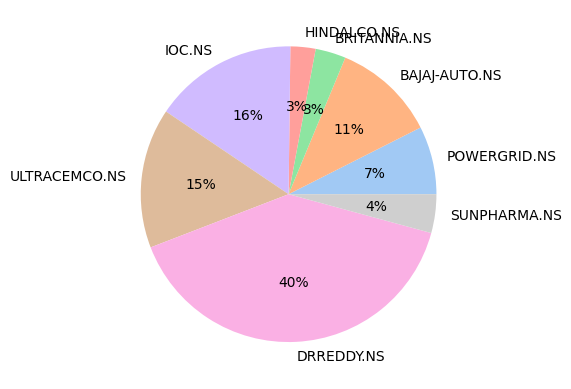

In [29]:
# explode = [0, 0, 0.2, 0.3, 0, 0.0, 0.0, 0.0]
# explode = [0.0,0,0,0.0,0.2,0,0,0,0,0.0]
plt.pie(stock_dict.values(), 
        labels=stock_dict.keys(), 
        colors=sns.color_palette('pastel'), 
        autopct='%.0f%%',
#         explode=explode
       )
plt.savefig(f'./results/{cfg.num_stocks}/qaoa_mvo_rc.png', bbox_inches='tight', pad_inches=0) 
plt.show()

### MSR post QAOA

In [30]:
study_qaoa_msr_rc = optuna.create_study(
    study_name='classical_qaoa_msr_rc',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)

study_qaoa_msr_rc.optimize(lambda trial: objective_msr_rc(trial, r_mu, r_sigma),
                           n_trials=25-len(study_qaoa_msr_rc.trials), n_jobs=1)

trial_qaoa_msr_rc = study_qaoa_msr_rc.best_trial
print(f'Best Sharpe ratio: {trial_qaoa_msr_rc.value}')
print(f"Best gamma: {trial_qaoa_msr_rc.params['gamma']}")

Best Sharpe ratio: 3.9922648177521074
Best gamma: 0.006514804372305033


In [31]:
cpo = ClassicalPO(r_mu, r_sigma, cfg)
cpo.cfg.gamma = trial_qaoa_msr_rc.params['gamma']
res = cpo.msr_rc()

# show only allocated stocks
weights = res['w']
stock_dict = dict(zip(tickers, np.around(weights, 5)))
stock_dict = {i: j for i, j in stock_dict.items() if j != 0}
pprint(stock_dict)

print(f"\nInvested in {len(stock_dict)}/{len(tickers)} stocks\n")
qaoa_msr_rc_res = cpo.get_metrics(weights)
qaoa_msr_rc_res

{'BAJAJ-AUTO.NS': 0.22547,
 'BRITANNIA.NS': 0.002,
 'DRREDDY.NS': 0.32772,
 'HINDALCO.NS': 0.13881,
 'IOC.NS': 0.06731,
 'POWERGRID.NS': 0.07157,
 'SUNPHARMA.NS': 0.002,
 'ULTRACEMCO.NS': 0.16513}

Invested in 8/16 stocks



{'returns': 0.3837271891827971,
 'risk': 0.09611766921785997,
 'sharpe_ratio': 3.9922648177521074,
 'diversification_ratio': 1.459160028096051}

In [32]:
stock_dict.keys()

dict_keys(['POWERGRID.NS', 'BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'HINDALCO.NS', 'IOC.NS', 'ULTRACEMCO.NS', 'DRREDDY.NS', 'SUNPHARMA.NS'])

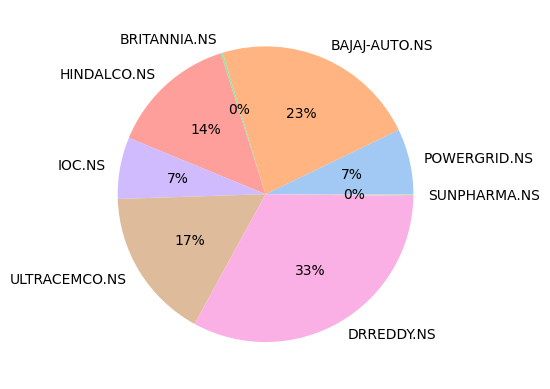

In [33]:
# explode = [0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0.0]
# explode = [0.0,0,0,0.0,0.3,0,0,0,0,0.0]
plt.pie(stock_dict.values(), 
        labels=stock_dict.keys(), 
        colors=sns.color_palette('pastel'), 
        autopct='%.0f%%',
#         explode=explode
       )
plt.savefig(f'./results/{cfg.num_stocks}/qaoa_msr_rc.png', bbox_inches='tight', pad_inches=0) 
plt.show()

## Anneal

In [34]:
import dimod
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import LeapHybridSampler

bqm = dimod.as_bqm(
    qubo.objective.linear.to_array(),
    qubo.objective.quadratic.to_array(),
    dimod.BINARY,
)

start = time()
sampler = SimulatedAnnealingSampler()
# sampler = LeapHybridSampler(token='DEV-3092b857364ac14474b6cca827ed602eda60252d')

end = time()
print("Duration:", end-start)

sample_set = sampler.sample(
    bqm,
#     num_reads=5000,
#     num_sweeps=1000,
#     seed=seed,
    label="BQM - Portfolio Optimization",
)

opt_bitstring = list(sample_set.first.sample.values())
print("Optimal bitstring:", opt_bitstring)

# select asset from bitstring
assets = []
for i, val in enumerate(opt_bitstring):
    if val == 1:
        assets.append(tickers[i])
        
# Reduced sigma and mu
idxs = np.nonzero([int(bit) for bit in opt_bitstring])[0]
r_sigma = sigma[idxs][:, idxs]
r_mu = mu[idxs]
print(r_sigma.shape, r_mu.shape)

Duration: 3.4332275390625e-05
Optimal bitstring: [0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
(8, 8) (8,)


### MVO post Anneal

In [35]:
study_anneal_mvo_rc= optuna.create_study(
    study_name='classical_anneal_mvo_rc',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)

study_anneal_mvo_rc.optimize(lambda trial: objective_mvo_rc(trial, r_mu, r_sigma),
                           n_trials=25-len(study_anneal_mvo_rc.trials), n_jobs=1)

trial_anneal_mvo_rc = study_anneal_mvo_rc.best_trial
print(f'Best Sharpe ratio: {trial_anneal_mvo_rc.value}')
print(f"Best gamma: {trial_anneal_mvo_rc.params['gamma']}")

Best Sharpe ratio: 3.8515714522221756
Best gamma: 0.5921747619108435


In [36]:
cpo = ClassicalPO(r_mu, r_sigma, cfg)
cpo.cfg.gamma = trial_anneal_mvo_rc.params['gamma']
res = cpo.mvo_rc()

# show only allocated stocks
weights = res['w']
stock_dict = dict(zip(tickers, np.around(weights, 5)))
stock_dict = {i: j for i, j in stock_dict.items() if j != 0}
pprint(stock_dict)

print(f"\nInvested in {len(stock_dict)}/{len(tickers)} stocks\n")
anneal_mvo_rc_res = cpo.get_metrics(weights)
anneal_mvo_rc_res

{'BAJAJ-AUTO.NS': 0.08045,
 'BRITANNIA.NS': 0.03272,
 'DRREDDY.NS': 0.17974,
 'HINDALCO.NS': 0.002,
 'IOC.NS': 0.002,
 'POWERGRID.NS': 0.14809,
 'SUNPHARMA.NS': 0.37303,
 'ULTRACEMCO.NS': 0.18197}

Invested in 8/16 stocks



{'returns': 0.4053215501006289,
 'risk': 0.10523537084240706,
 'sharpe_ratio': 3.8515714522221756,
 'diversification_ratio': 1.4287206115835807}

In [37]:
stock_dict.keys()

dict_keys(['POWERGRID.NS', 'BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'HINDALCO.NS', 'IOC.NS', 'ULTRACEMCO.NS', 'DRREDDY.NS', 'SUNPHARMA.NS'])

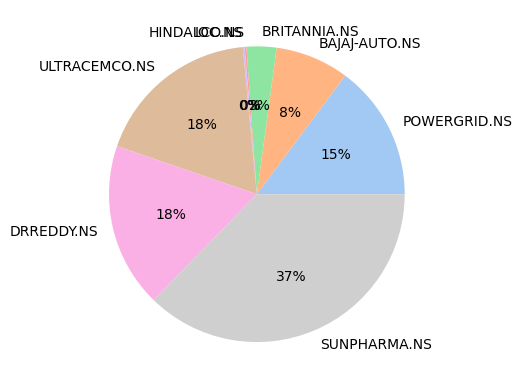

In [39]:
# explode = [0, 0, 0.2, 0.3, 0, 0.0, 0.0, 0.0]
# explode = [0.0,0,0,0.0,0,0,0,0,0,0.0]
plt.pie(stock_dict.values(), 
        labels=stock_dict.keys(), 
        colors=sns.color_palette('pastel'), 
        autopct='%.0f%%',
#         explode=explode
       )
plt.savefig(f'./results/{cfg.num_stocks}/anneal_mvo_rc.png', bbox_inches='tight', pad_inches=0) 
plt.show()

### MSR post Anneal

In [40]:
study_anneal_msr_rc = optuna.create_study(
    study_name='classical_anneal_msr_rc',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)

study_anneal_msr_rc.optimize(lambda trial: objective_msr_rc(trial, r_mu, r_sigma),
                           n_trials=25-len(study_anneal_msr_rc.trials), n_jobs=1)

trial_anneal_msr_rc = study_anneal_msr_rc.best_trial
print(f'Best Sharpe ratio: {trial_anneal_msr_rc.value}')
print(f"Best gamma: {trial_anneal_msr_rc.params['gamma']}")

Best Sharpe ratio: 3.972725382396315
Best gamma: 0.010853270568067955


In [41]:
cpo = ClassicalPO(r_mu, r_sigma, cfg)
cpo.cfg.gamma = trial_anneal_msr_rc.params['gamma']
res = cpo.msr_rc()

# show only allocated stocks
weights = res['w']
stock_dict = dict(zip(tickers, np.around(weights, 5)))
stock_dict = {i: j for i, j in stock_dict.items() if j != 0}
pprint(stock_dict)

print(f"\nInvested in {len(stock_dict)}/{len(tickers)} stocks\n")
anneal_msr_rc_res = cpo.get_metrics(weights)
anneal_msr_rc_res

{'BAJAJ-AUTO.NS': 0.13611,
 'BRITANNIA.NS': 0.02321,
 'DRREDDY.NS': 0.18215,
 'HINDALCO.NS': 0.002,
 'IOC.NS': 0.002,
 'POWERGRID.NS': 0.22337,
 'SUNPHARMA.NS': 0.34449,
 'ULTRACEMCO.NS': 0.08666}

Invested in 8/16 stocks



{'returns': 0.38900676501924625,
 'risk': 0.09791936959523756,
 'sharpe_ratio': 3.972725382396315,
 'diversification_ratio': 1.4571854273606826}

In [42]:
stock_dict.keys()

dict_keys(['POWERGRID.NS', 'BAJAJ-AUTO.NS', 'BRITANNIA.NS', 'HINDALCO.NS', 'IOC.NS', 'ULTRACEMCO.NS', 'DRREDDY.NS', 'SUNPHARMA.NS'])

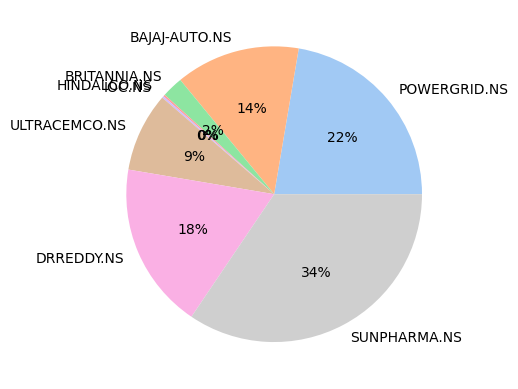

In [43]:
# explode = [0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0.0]
# explode = [0.0,0,0,0.0,0.0,0.2,0,0,0,0.0]
plt.pie(stock_dict.values(), 
        labels=stock_dict.keys(), 
        colors=sns.color_palette('pastel'), 
        autopct='%.0f%%',
#         explode=explode
       )
plt.savefig(f'./results/{cfg.num_stocks}/anneal_msr_rc.png', bbox_inches='tight', pad_inches=0) 
plt.show()

## Plot

In [44]:
def generate_random_input(n):
    z = []
    for _ in range(n):
        arr = np.concatenate((np.ones(cfg.kappa), np.zeros(cfg.num_stocks - cfg.kappa))).astype(int)
        np.random.shuffle(arr)
        z.append(arr)
    return np.array(z)

In [45]:
cpo = ClassicalPO(mu, sigma, cfg)
cpo.cfg.gamma = trial_msr_rc.params['gamma']

## CALCULATE RISKS AND RETURNS FOR FRONTIER
N = 100
metrics = []
qs = 10**(5.0 * np.arange(N)/N - 1.0)
for t in range(N):
    cpo.cfg.q = qs[t]
    res = cpo.mvo_miqp()
    metrics += [cpo.get_metrics(res['w'])]
    
ef = pd.DataFrame(metrics)
ef['q'] = qs

In [46]:
cfg.num_stocks

16

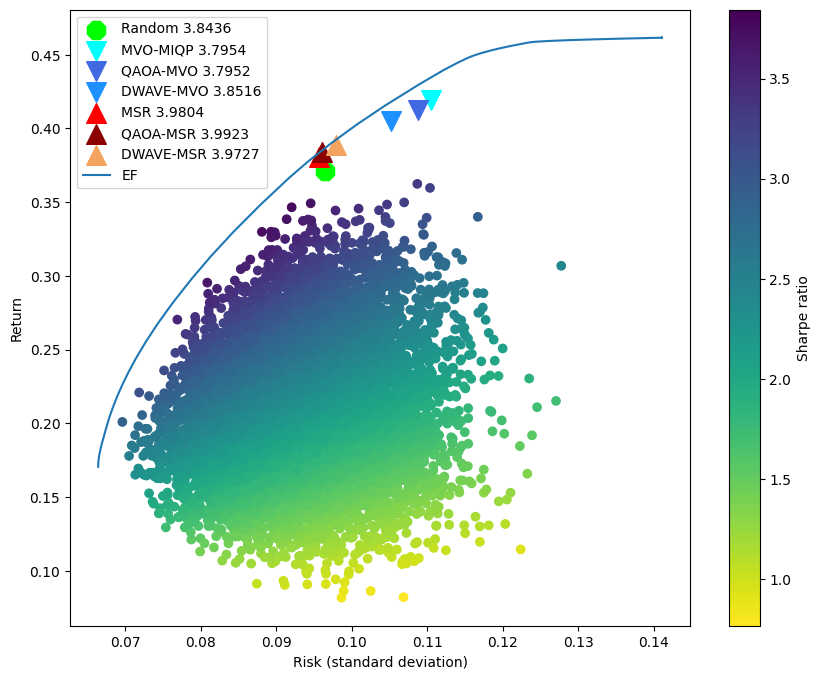

In [47]:
num_portfolios = 10000

# Generate random portfolios with weights summing to 1
# with kappa stocks selected
wts = np.random.random((num_portfolios, cfg.num_stocks))
z = generate_random_input(num_portfolios)
wts *= z
wts /= np.expand_dims(wts.sum(axis=1), axis=1)

# Calculate return, standard deviation, and Sharpe ratio of each random portfolio
risks = np.sqrt(np.sum((sigma @ wts.T) * wts.T, axis=0))
returns = wts @ mu
sharpe_ratios = returns / risks

# Plot the random portfolios and the optimal portfolio
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(risks, returns, c=sharpe_ratios, cmap="viridis_r")
fig.colorbar(s, label="Sharpe ratio", ax=ax)
ax.set_xlabel("Risk (standard deviation)")
ax.set_ylabel("Return")

labels = [
    f"MVO-MIQP {mvo_miqp_res['sharpe_ratio']:.4f}",
    f"QAOA-MVO {qaoa_mvo_rc_res['sharpe_ratio']:.4f}",
    f"DWAVE-MVO {anneal_mvo_rc_res['sharpe_ratio']:.4f}",
    f"MSR {msr_res['sharpe_ratio']:.4f}",
    f"QAOA-MSR {qaoa_msr_rc_res['sharpe_ratio']:.4f}",
    f"DWAVE-MSR {anneal_msr_rc_res['sharpe_ratio']:.4f}",
]

idx = np.argmax(sharpe_ratios)

ax.scatter(risks[idx], returns[idx], marker="8", c="lime", s=200, label=f'Random {sharpe_ratios[idx]:.4f}')

ax.scatter(mvo_miqp_res['risk'], mvo_miqp_res['returns'], marker="v", c="cyan", s=200, label=labels[0])
ax.scatter(qaoa_mvo_rc_res['risk'], qaoa_mvo_rc_res['returns'], marker="v", c="royalblue", s=200, label=labels[1])
ax.scatter(anneal_mvo_rc_res['risk'], anneal_mvo_rc_res['returns'], marker="v", c="dodgerblue", s=200, label=labels[2])

ax.scatter(msr_res['risk'], msr_res['returns'], marker="^", c="red", s=200, label=labels[3])
ax.scatter(qaoa_msr_rc_res['risk'], qaoa_msr_rc_res['returns'], marker="^", c="darkred", s=200, label=labels[4])
ax.scatter(anneal_msr_rc_res['risk'], anneal_msr_rc_res['returns'], marker="^", c="sandybrown", s=200, label=labels[5])


# efficient frontier
ax.plot(ef['risk'], ef['returns'], label='EF')

ax.legend()
plt.savefig(f'./results/{cfg.num_stocks}/PO.png', bbox_inches='tight', pad_inches=0) 
plt.show()

In [48]:
# generate latex table
algos = ['Classical MVO', 'QAOA MVO', 'DWAVE MVO', "Classical MSR", 'QAOA MSR', 'DWAVE MSR']
data = [
    mvo_miqp_res,
    qaoa_mvo_rc_res,
    anneal_mvo_rc_res,
    msr_res,
    qaoa_msr_rc_res,
    anneal_msr_rc_res,
]
texdata = ""
for algo, res in zip(algos, data):
    texdata += f"{algo} & {res['risk'] * 100:.3f} & {res['returns'] * 100:.3f} & "
    texdata += f"{res['sharpe_ratio'] :.3f} & {res['diversification_ratio']:.3f} \\\\ \n"

print(texdata)

Classical MVO & 11.042 & 41.908 & 3.795 & 1.371 \\ 
QAOA MVO & 10.878 & 41.285 & 3.795 & 1.384 \\ 
DWAVE MVO & 10.524 & 40.532 & 3.852 & 1.429 \\ 
Classical MSR & 9.568 & 38.083 & 3.980 & 1.470 \\ 
QAOA MSR & 9.612 & 38.373 & 3.992 & 1.459 \\ 
DWAVE MSR & 9.792 & 38.901 & 3.973 & 1.457 \\ 

